In [3]:
import numpy as np 
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import sparse
from scipy.sparse.linalg import spsolve
import math
from matplotlib import patheffects
from scipy.optimize import minimize


# Structural optimization assignment no. 2
## Author: Donglai Yang

# Problem 1
## This question is based on the truss below. Show a derivation for all expressions. It would be a good idea, but is not required, to use your code to verify your answers.

### Find the reduced global stiffness matrix as a function of the design variables

Response: Here I am using SymPy to help with assembling the global stiffness matrix. Here I consulted Claude for SymPy syntax.

In [ ]:
import numpy as np
import sympy as sp
from sympy import symbols, Matrix, sqrt, simplify
from sympy import hessian


# Define symbolic variables
x1, x2 = symbols('x1 x2', real=True, positive=True)
L_sym = symbols('L', real=True, positive=True)


class SymbolicTruss:
    def __init__(self, conn, xpos, bcs, force):
        self.conn = conn
        self.xpos = xpos
        self.bcs = bcs
        self.force = force
        self.n_nodes = len(xpos)
        self.n_dof = 2 * self.n_nodes
        
    def compute_element_stiffness_symbolic(self, node1, node2, A_elem, E, L):
        """Compute element stiffness matrix"""
        x1, y1 = self.xpos[node1]
        x2, y2 = self.xpos[node2]
        
        length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        c = (x2 - x1) / length
        s = (y2 - y1) / length
        
        # Element stiffness matrix in global coordinates
        k_elem = (E * A_elem / length) * Matrix([
            [c**2, c*s, -c**2, -c*s],
            [c*s, s**2, -c*s, -s**2],
            [-c**2, -c*s, c**2, c*s],
            [-c*s, -s**2, c*s, s**2]
        ])
        
        return k_elem
    
    def assemble_stiffness_matrix_symbolic(self, A_array, E, L):
        K = Matrix.zeros(self.n_dof, self.n_dof)
        
        for i, (node1, node2) in enumerate(self.conn):
            k_elem = self.compute_element_stiffness_symbolic(node1, node2, A_array[i], E, L)
            dofs = [2*node1, 2*node1+1, 2*node2, 2*node2+1]
            
            # Assemble into global matrix
            for ii, dof_i in enumerate(dofs):
                for jj, dof_j in enumerate(dofs):
                    K[dof_i, dof_j] += k_elem[ii, jj]
        
        return K
    
    def reduce_matrix_symbolic(self, K):
        """Apply boundary conditions to get reduced stiffness matrix"""
        free_dofs = [i for i in range(self.n_dof) if i not in self.bcs]
        
        # Extract reduced matrix
        Kr = Matrix.zeros(len(free_dofs), len(free_dofs))
        for i, dof_i in enumerate(free_dofs):
            for j, dof_j in enumerate(free_dofs):
                Kr[i, j] = K[dof_i, dof_j]
        
        return Kr, free_dofs
    
    def reduce_vector_symbolic(self, F):
        """boundary conditions to force vector"""
        free_dofs = [i for i in range(self.n_dof) if i not in self.bcs]
        Fr = Matrix([F[i] for i in free_dofs])
        return Fr
    
    def compute_mass(self, A_array, density=1.0):
        """total mass of the truss"""
        mass = 0
        for i, (node1, node2) in enumerate(self.conn):
            x1, y1 = self.xpos[node1]
            x2, y2 = self.xpos[node2]
            length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
            mass += density * A_array[i] * length
        return mass
    
L_val = 1  
xpos = [[0,0], [L_val,-L_val], [L_val,L_val], [2*L_val,0]]
conn = [[0,1], [1,3], [2,3], [0,2], [1,2]]
bcs = [0,1,6,7]
force = [0,0,0,-2,0,0,0,0]  

symbolic_truss = SymbolicTruss(conn, xpos, bcs, force)
A_symbolic = Matrix([x2, x2, sqrt(2)*x1, sqrt(2)*x1, x2]) # area variables, taken on function of x1 and x2

# symbolic stiffness matrix
K_symbolic = symbolic_truss.assemble_stiffness_matrix_symbolic(A_symbolic, 1, L_sym)
Kr_symbolic, free_dofs = symbolic_truss.reduce_matrix_symbolic(K_symbolic)
Fr_symbolic = symbolic_truss.reduce_vector_symbolic(force)

print("\nReduced Stiffness Matrix:")
print(Kr_symbolic)

print("\nReduced Force Vector:")
print(Fr_symbolic)



Reduced Stiffness Matrix:
Matrix([[sqrt(2)*x2/2, 0, 0, 0], [0, x2/2 + sqrt(2)*x2/2, 0, -x2/2], [0, 0, x1, 0], [0, -x2/2, 0, x1 + x2/2]])

Reduced Force Vector:
Matrix([[0], [-2], [0], [0]])


### (b) Derive an expression for the compliance and the mass of the truss

The mass of the truss is straight-forward. Please consult the hand-written page for the derivation. 

To calculate the compliance, we need to compute the inverse of stiffness matrix as $c(x_1, x_2) = f_r^T K^{-1}_r f_r$. The inverse of the 4x4 matrix wasn't straight-forward to compute so I consulted SymPy. 

In [9]:
print("\n matrix inverse Kr^-1:")
print(Kr_symbolic.inv())
# simplify the inverse matrix
Kr_inv_simplified = simplify(Kr_symbolic.inv())
print("\nSimplified Kr^-1:")
print(Kr_inv_simplified)

# compute the compliance c(x1,x2) = f^T * K^-1 * f
compliance_symbolic = (Fr_symbolic.T * Kr_inv_simplified * Fr_symbolic)[0]
compliance_symbolic_simplified = simplify(compliance_symbolic)
print("\nCompliance:")
print(compliance_symbolic_simplified)



 matrix inverse Kr^-1:
Matrix([[sqrt(2)/x2, 0, 0, 0], [0, (4*x1 + 4*sqrt(2)*x1 + 2*x2 + 2*sqrt(2)*x2)/(4*sqrt(2)*x1*x2 + 6*x1*x2 + sqrt(2)*x2**2 + 2*x2**2), 0, (2 + 2*sqrt(2))/(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)], [0, 0, 1/x1, 0], [0, 2/(2*x1 + 2*sqrt(2)*x1 + sqrt(2)*x2), 0, (2 + 2*sqrt(2))/(2*x1 + 2*sqrt(2)*x1 + sqrt(2)*x2)]])

Simplified Kr^-1:
Matrix([[sqrt(2)/x2, 0, 0, 0], [0, 2*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)), 0, 2*(1 + sqrt(2))/(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)], [0, 0, 1/x1, 0], [0, 2/(2*x1 + 2*sqrt(2)*x1 + sqrt(2)*x2), 0, 2*(1 + sqrt(2))/(2*x1 + 2*sqrt(2)*x1 + sqrt(2)*x2)]])

Compliance:
8*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2))


### (d) show that the Hessian of the compliance is positive definite for all positive values of the design variables

Again, compliance is a complicated function of $x_1, x_2$ so I consulted SymPy. The Hessian it computes appears exceedingly difficult to factor out to express as $\alpha v^T v >0$ which is lecture examples used to prove that the matrix is positive semi-definite. Instead I ask SymPy to directly compute the eigenvalues and both are shown to be positive with a positive $x_1, x_2$ as they are sum of powers with positive coefficients (see below), so the Hessian is positive semi-definite.

In [10]:
# compute its hessian matrix
hessian_symbolic = hessian(compliance_symbolic_simplified, [x1, x2])
hessian_symbolic_simplified = simplify(hessian_symbolic)
print("\nHessian of Compliance:")
print(hessian_symbolic)

# eigenvalues of the hessian matrix
eigenvals = hessian_symbolic_simplified.eigenvals()
print("\nEigenvalues of Hessian:")
for val, mult in eigenvals.items():
    print(f"Eigenvalue: {val}, Multiplicity: {mult}")


Hessian of Compliance:
Matrix([[8*(-12 - 8*sqrt(2))*(-6 - 4*sqrt(2))*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**3) + 16*(-6 - 4*sqrt(2))*(2 + 2*sqrt(2))/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**2), 8*(-6 - 4*sqrt(2))*(-4 - 2*sqrt(2))*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**3) + 8*(-6 - 4*sqrt(2))*(1 + sqrt(2))/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**2) + 8*(-2 - sqrt(2))*(2 + 2*sqrt(2))/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**2) - 8*(-6 - 4*sqrt(2))*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2**2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**2) - 8*(2 + 2*sqrt(2))/(x2**2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2))], [8*(-6 - 4*sqrt(2))*(-4 - 2*sqrt(2))*(2*x1 + 2*sqrt(2)*x1 + x2 + sqrt(2)*x2)/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**3) + 8*(-6 - 4*sqrt(2))*(1 + sqrt(2))/(x2*(4*sqrt(2)*x1 + 6*x1 + sqrt(2)*x2 + 2*x2)**2) + 8*(-2 - sqrt(2))*(2 + 2*sqrt(2))/(x2*(4*sqrt(2)*x1 + 6*

### (d) Plot the design space for the mass constrained compliance minimization problem. Illustrate the feasible space and show the constrained minimizer. 

Response: the plot below shows the design space. Visually one can see that the optimal point should be where x1 has minimal value while x2 has the highest values under the mass inequality constraint (approximately x1=0, x2=0.2)

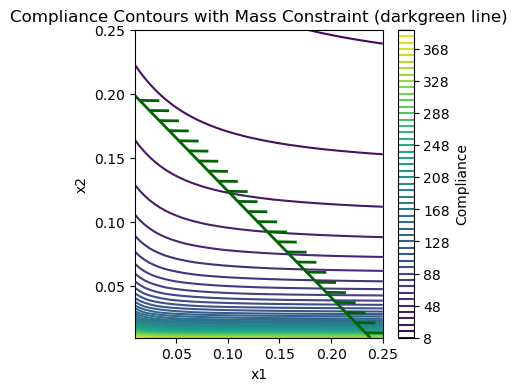

In [7]:
# make a plot of the design space
nx = 50
x1 = np.linspace(0.01, 0.25, nx)
x2 = np.linspace(0.01, 0.25, nx)
X1, X2 = np.meshgrid(x1, x2)

m_fixed = 1.0

def compute_mass(x):
    x1, x2 = x
    return 4*x1 + (2*np.sqrt(2)+2)*x2

# use the symbolic expression from earlier
def compute_compliance(x):
    x1, x2 = x
    return 8*(2*x1+2*np.sqrt(2)*x1 + x2 + np.sqrt(2)*x2)/(x2*(4*np.sqrt(2)*x1 + 6*x1 + np.sqrt(2)*x2 + 2*x2))

def compute_compliance_gradient_finite_diff(x, h=1e-6):
    """Compute gradient of compliance using finite difference"""
    x1, x2 = x
    c = compute_compliance(x)
    dc_dx1 = (compute_compliance([x1 + h, x2]) - c) / h
    dc_dx2 = (compute_compliance([x1, x2 + h]) - c) / h
    return np.array([dc_dx1, dc_dx2])

# compute compliance
C = compute_compliance([X1, X2])

fig, ax = plt.subplots(figsize=(4, 4))
contours = ax.contour(X1, X2, C, levels=50, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.colorbar(contours, ax=ax, label='Compliance')

# create mass constraint
cm = compute_mass([X1, X2]) - m_fixed
c1 = plt.contour(X1, X2, cm, [0.0], colors='darkgreen', linewidths=2)
c1.set_path_effects([patheffects.withTickedStroke()])
plt.title('Compliance Contours with Mass Constraint (darkgreen line)')
plt.show()

### (e) find the design variable values at the constrained minimizer

Response: to find the minimal point with scipy minimizer. 

In [54]:
res = minimize(compute_compliance, 
               x0=[0.1,0.1],
               jac=compute_compliance_gradient_finite_diff,
               constraints=
               {'type':'ineq',
                'fun': lambda x: m_fixed - compute_mass([x[0], x[1]])},
                bounds=[(0.01,0.25),(0.01,0.25)])
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 26.39811892510659
       x: [ 2.635e-02  1.853e-01]
     nit: 5
     jac: [-1.056e+02 -1.275e+02]
    nfev: 5
    njev: 5


In [11]:
class Truss:
    def __init__(self, conn, x, bcs, f, E=10.0, rho=0.1, A_scale=1e-3, compliance_scale=1e3):
        self.conn = np.array(conn, dtype=int)
        self.x = np.array(x)
        self.bcs = np.array(bcs, dtype=int)
        self.f = np.array(f)
        self.E = E
        self.rho = rho
        self.A_scale = A_scale
        self.compliance_scale = compliance_scale

        # Extract the number of nodes and elements
        self.nnodes = self.x.shape[0]
        self.nelems = self.conn.shape[0]

        # Form the reduced set of degrees of freedom
        self.reduced = np.setdiff1d(np.arange(2*self.nnodes), self.bcs)

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.elem_vars = np.array((2*self.conn[:,0],
                                   2*self.conn[:,0]+1,
                                   2*self.conn[:,1],
                                   2*self.conn[:,1]+1)).T
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.elem_vars[index, :]:
                for jj in self.elem_vars[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

        return

    def assemble_stiffness_matrix(self, A):
        """
        Assemble the stiffness matrix
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*A*Le

        # Compute all of the element matrices
        Ke = np.zeros((self.nelems, 4, 4), dtype=A.dtype)
        for i in range(self.nelems):
            Ke[i,:] = scale[i]*np.outer(B[i,:], B[i,:])

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K


    def compliance(self, A):
        """
        Given the cross-sectional areas, compute the compliance
        """
        u = self.solve(A)
        result = np.dot(u, self.f)
        
        return result
    
    def compliance_scaled(self, A):
        """
        Given the cross-sectional areas, compute the scaled compliance
        """
        u = self.solve(A)
        return np.dot(u, self.f)/self.compliance_scale
    
    def compliance_Ahat(self, Ahat):
        """
        Given the scaled cross-sectional areas, compute the compliance
        """
        # Assume Ahat = A / A_scale
        A = Ahat * self.A_scale
        u = self.solve(A)
        result = np.dot(u, self.f)
        return result

    def compliance_gradient(self, A):
        """
        Given the cross-sectional areas, compute the compliance gradient
        """

        u = self.solve(A)

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = u[self.elem_vars]
        strain = np.sum(B*ue, axis=1)

        scale = self.E*Le
        dcdA = -scale*strain**2

        return dcdA
    
    def compliance_gradient_Ahat(self, Ahat):
        """
        Given the scaled cross-sectional areas, compute the compliance gradient
        """
        # Assume Ahat = A / A_scale
        A = Ahat * self.A_scale
        u = self.solve(A)

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = u[self.elem_vars]
        strain = np.sum(B*ue, axis=1)

        scale = self.E*Le
        dcdA = -scale*strain**2

        # Chain rule to account for scaling: dC/dAhat = dC/dA * dA/dAhat
        dcdAhat = dcdA * self.A_scale

        return dcdAhat
    
    def compliance_scaled_gradient(self, A):
        """
        Given the cross-sectional areas, compute the scaled compliance gradient
        """

        dcdA = self.compliance_gradient(A)
        return dcdA / self.compliance_scale

    def compute_stresses(self, u):
        """
        Compute the stresses in each element
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = np.array((u[2*self.conn[:,0]],
                       u[2*self.conn[:,0]+1],
                       u[2*self.conn[:,1]],
                       u[2*self.conn[:,1]+1])).T

        stress = self.E*np.sum(B*ue, axis=1)
        return stress
    
    def compute_strains(self, u):
        stress = self.compute_stresses(u)
        return stress / self.E
    
    def compute_max_strain(self, u):
        strain = self.compute_strains(u)
        # need absolute value
        return np.max(np.abs(strain))

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def solve(self, A):
        """
        Perform a linear static analysis
        """

        K = self.assemble_stiffness_matrix(A)
        Kr = self.reduce_matrix(K)
        fr = self.reduce_vector(self.f)

        ur = sparse.linalg.spsolve(Kr, fr)

        u = np.zeros(2*self.nnodes, dtype=ur.dtype)
        u[self.reduced] = ur

        return u
    
    def plot(self, u=None, scale=1.0, **kwargs):
        """
        Visualize the truss and optionally its deformation.
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        if u is not None:
            x = self.x + scale*u.reshape((-1, 2))
        else:
            x = self.x

        for index in range(self.nelems):
            i = self.conn[index, 0]
            j = self.conn[index, 1]
            plt.plot([x[i,0], x[j,0]], [x[i,1], x[j,1]], '-ko')

        ax.set_axis_off()
        ax.axis('equal')
        fig.tight_layout()

        return
    
    def plot_areas(self, A, **kwargs):
        """
        Plot the bar areas
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        stress = self.compute_stresses(self.solve(A))

        cm = plt.get_cmap('coolwarm')
        cNorm = colors.Normalize(vmin=min(stress), vmax=max(stress))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        for index, bar in enumerate(conn):
            n1 = bar[0]
            n2 = bar[1]
            if A[index] >= 1e-4*max(A):
                plt.plot([self.x[n1, 0], self.x[n2, 0]],
                         [self.x[n1, 1], self.x[n2, 1]],
                         color=scalarMap.to_rgba(stress[index]),
                         linewidth=5*(A[index]/max(A)))

        ax.axis('equal')
        ax.set_axis_off()
        fig.tight_layout()

        return
    
    def finite_difference_real_grad(self, x_vec, func, h=1e-8):
        # compute the finite difference gradient for a function at x_vec
        # where x_vec can be any length
        dfdx = np.zeros(len(x_vec))
        for i in range(len(x_vec)):
            x_plus_h = np.array(x_vec, dtype=float)
            x_plus_h[i] += h
            f_plus_h = func(x_plus_h)
            f0 = func(x_vec)
            dfdx[i] = (f_plus_h - f0)/h
        return dfdx
                
    def finite_difference_complex_grad(self, x_vec, func, h=1e-8):  # larger h
        dfdx = np.zeros(len(x_vec))
        for i in range(len(x_vec)):
            x_plus_ih = np.array(x_vec, dtype=complex)
            x_plus_ih[i] += 1j*h
            f_plus_ih = func(x_plus_ih)
            dfdx[i] = np.imag(f_plus_ih)/h
        return dfdx




# Problem 2
Write an analysis and optimization code for mass-constrained compliance minimization and
apply it on the truss illustrated below. Use the methods presented in class to determine the derivative of
the compliance with respect to the design variables. This code should supply the gradients of the objective
and constraints to the optimizer to avoid finite-differening.

### (a): Check your implementation of the compliance derivative using finite-difference and complex-step method. Make a relative error vs. step size plot that shows that your code computes the correct gradient.


Analytical Gradient: [ -2052.024876    -2052.024876    -5804.00281992 -18645.30975524
  -4219.18932401  -2919.71685496 -23607.86993017  -2086.03715083
  -3683.61138921  -1039.64424152  -1773.31455444 -33750.85231453
   -102.59220434   -102.59220434  -4280.24021244  -1773.31455444
 -23607.86993017  -3683.61138921  -2086.03715083  -1039.64424152
  -2919.71685496  -2052.024876   -18645.30975524  -5804.00281992
  -4219.18932401  -2052.024876  ]


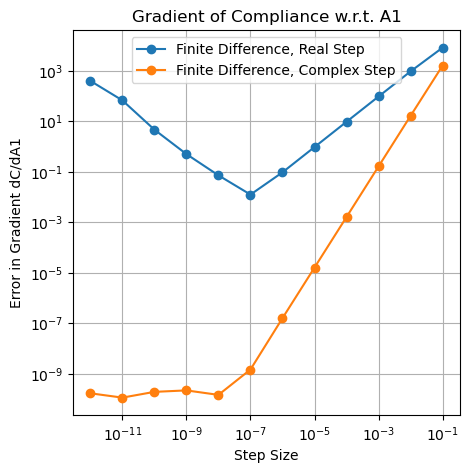

In [134]:
L = 1
rho = 1.0
E = 1000
P = 1000
m_fixed = (10.0*np.sqrt(2) +16.0)*L

xpos = [[0,0],[0,L],[L,L],[L,0],[2*L,0],[2*L,L],[3*L,L],[3*L,0], [4*L,0],[4*L,L],[5*L,L],[5*L,0]]
conn = [[0,1],[1,2],[1,3],[0,2],[0,3],[2,3],[2,5],[2,4],[3,5],[3,4],[4,5],[5,6],[5,7],[4,6],[4,7],[7,6],[6,9],[6,8],[7,9],[7,8],[8,9],[9,10],[9,11],[8,10],[8,11],[10,11]]
bcs = [0,1,22,23]
force = [0,0,0,0,
         0,0,-P/4,-P,
         0,-P,0,0,
         0,0,0,-P,
         P/4,-P,0,0,
         0,0,0,0]


prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

# choose a point to evaluate the gradients
A = 0.5*np.ones(len(conn))
# evaluate the gradients with various step sizes
hvals = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

# finite difference, real step
compliance_grads_fd_real    = np.zeros((len(hvals), len(conn)))
compliance_grads_fd_complex = np.zeros((len(hvals), len(conn)))
compliance_grads_analytical = prob2.compliance_gradient(A)
print("Analytical Gradient:", compliance_grads_analytical)

for i, h in enumerate(hvals):
    compliance_grads_fd_real[i, :]    = prob2.finite_difference_real_grad(A, prob2.compliance, h)
    compliance_grads_fd_complex[i, :] = prob2.finite_difference_complex_grad(A, prob2.compliance, h)

# plot the results
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.loglog(hvals, np.linalg.norm(compliance_grads_fd_real.T-compliance_grads_analytical.reshape(-1,1),axis=0), '-o', label='Finite Difference, Real Step')
axs.loglog(hvals, np.linalg.norm(compliance_grads_fd_complex.T-compliance_grads_analytical.reshape(-1,1),axis=0), '-o', label='Finite Difference, Complex Step')
axs.set_xlabel('Step Size')
axs.set_ylabel('Error in Gradient dC/dA1')
axs.set_title('Gradient of Compliance w.r.t. A1')
axs.legend()
axs.grid(True)

### (b): Find an appropriatel scaling for the design variables, the objective and the constraints. Report what you find.

My response: the problem requires minimizing the compliance, while the mass is under m_{fixed}. In the script below, I consider several cases: (1) unscaled case, (2) design variable scaling, (3) mass inequality constraint scaling, and (4) objective function scaling. All of these scaling are basically taking a ratio with respect to a reference value. From the numeric experiment, I found that the objective function scaling (scaled compliance) delivers the best performance, which means the smallest number of iterations toward the convergence (total 18); on the contrary, the design variable scaling for this problem has the largest number of iterations and thus the worst performance. For all the scaling and all the solutions, the mass inequality is always an active constraint, and all lead to the same solution and shape of the deflected structure.

#### Case 1. no scaling

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19923.727013128337
       x: [ 1.085e-07  1.085e-07 ...  3.468e-01  2.233e-08]
     nit: 23
     jac: [-2.678e+02 -2.678e+02 ... -5.195e+02 -1.208e+02]
    nfev: 55
    njev: 23


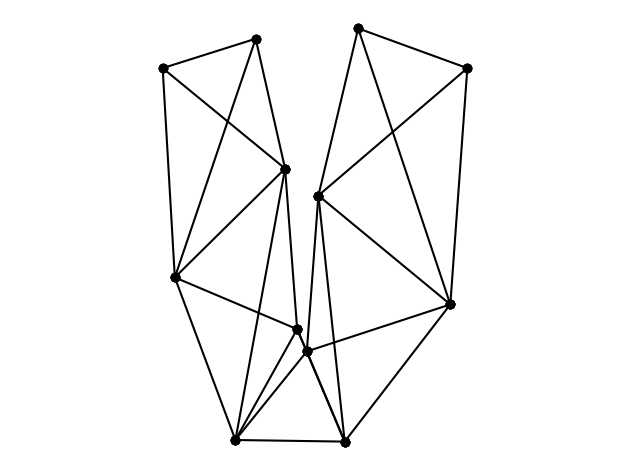

Mass is  30.14210790601166 , and mass limit is  30.14213562373095


In [ ]:
# For the optimization problem, set the initial bar areas
x0 = np.ones(len(conn))
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

# Compute the gradient of the mass of the truss
xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

# no scaling
res = minimize(prob2.compliance, x0, 
               jac=prob2.compliance_gradient,
               method='SLSQP',
               bounds=[(1e-12, 10.0)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: (m_fixed - np.dot(m0, x)),
                             'jac': lambda x: -np.array(m0)}])

# Show the bar areas
print(res)

# plot
u = prob2.solve(res.x)
prob2.plot(u=u)
plt.show()

print('Mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)

#### Case 2: scaled design variable

/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19914.84711329102
       x: [ 1.000e-01  1.000e-01 ...  3.076e+02  1.000e-01]
     nit: 322
     jac: [-1.134e-01 -1.134e-01 ... -6.607e-01 -1.134e-01]
    nfev: 377
    njev: 322


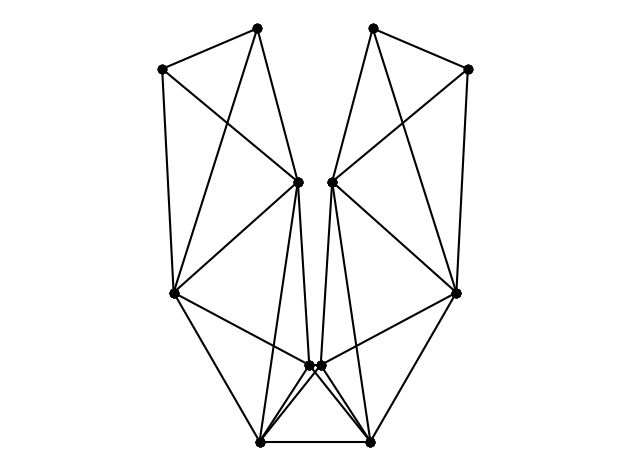

Optimized mass is  30.14213562373478 , and mass limit is  30.14213562373095
Optimized compliance is  19914.84711329102


In [ ]:
# Use scaled design variable
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = prob2.rho * Le  

Ahat_min = 0.1  # Minimum Ahat (actual A = 1e-4)
Ahat_max = 1e8  # Maximum Ahat (actual A = 0.1)
bounds = [(Ahat_min, Ahat_max)] * len(conn)

Ahat_init = 10.0 * np.ones(len(conn)) 

res = minimize(prob2.compliance_Ahat, 
              Ahat_init,
              jac=prob2.compliance_gradient_Ahat,
              method='SLSQP',
              bounds=bounds,
              constraints=[{'type': 'ineq',
                          'fun': lambda x: (m_fixed - np.dot(m0, x * prob2.A_scale)),  # Note scaling here
                          'jac': lambda x: -m0 * prob2.A_scale}],
              options={'ftol': 1e-8, 'maxiter': 1000})

print(res)

u = prob2.solve(res.x * prob2.A_scale)
prob2.plot(u=1*u)
plt.show()

print('Optimized mass is ', np.dot(m0, res.x * prob2.A_scale),', and mass limit is ', m_fixed)
print('Optimized compliance is ', prob2.compliance_Ahat(res.x))


#### Case 3: use scaled mass inequality constraint

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19914.236023139998
       x: [ 8.424e-08  8.424e-08 ...  3.043e-01  2.756e-08]
     nit: 31
     jac: [-1.872e+02 -1.872e+02 ... -6.751e+02 -1.136e+02]
    nfev: 66
    njev: 31


/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


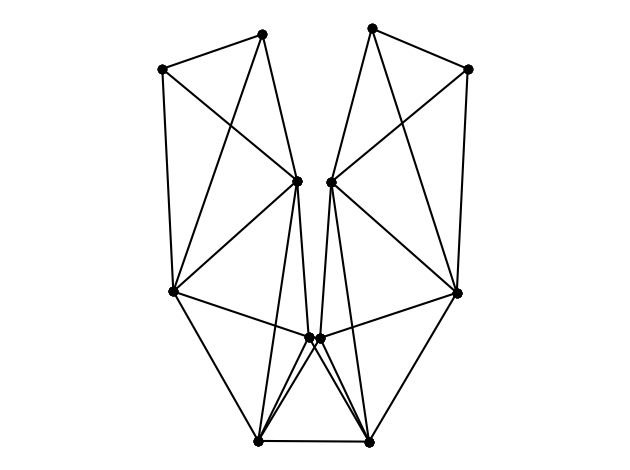

Optimized mass is  30.142137997742587 , and mass limit is  30.14213562373095


In [ ]:
# use mass inequality constraint scaling: m/m_{fixed} - 1 <= 0
# this in scipy optimizer is 1-m/m_{fixed} >= 0
# we do not scale the design variable here
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

x0 = np.ones(len(conn))
# Compute the gradient of the mass of the truss
xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le/m_fixed  # account for scaling

res = minimize(prob2.compliance, x0,
               jac=prob2.compliance_gradient,
               method='SLSQP',
               bounds=[(1e-12, 1e5)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: 1 - np.dot(m0, x),
                             'jac': lambda x: -m0}])

print(res)

u = prob2.solve(res.x)
prob2.plot(u=u)
plt.show()
print('Optimized mass is ', np.dot(m0, res.x)*m_fixed,', and mass limit is ', m_fixed)

#### Case 4: scaled objective (scaled compliance)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19.913983892838427
       x: [ 1.000e-08  1.000e-08 ...  3.076e-01  1.000e-08]
     nit: 18
     jac: [-5.196e-02 -5.196e-02 ... -6.604e-01 -5.197e-02]
    nfev: 489
    njev: 18


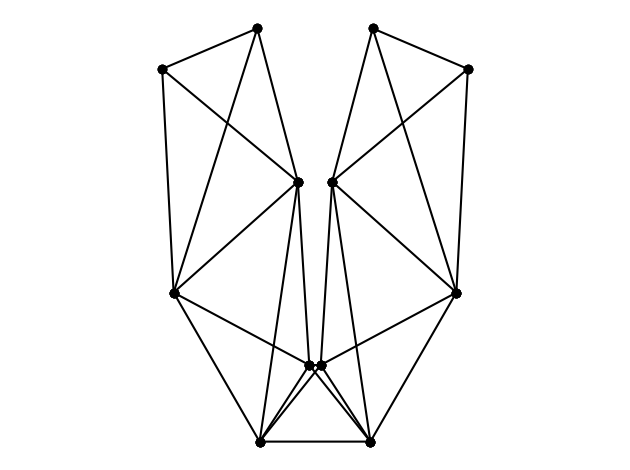

Optimized mass is  30.142135623730958 , and mass limit is  30.14213562373095
Optimized compliance is  19913.983892838427


In [ ]:
# consider objective scaling
# others unscaled
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

x0 = 1*np.ones(len(conn))
# Compute the gradient of the mass of the truss
xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

res = minimize(prob2.compliance_scaled, x0, 
               #jac=prob2.compliance_gradient_Ahat,
               method='SLSQP',
               bounds=[(1e-8, 1e3)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: (m_fixed - np.dot(m0, x)),
                             'jac': lambda x: -np.array(m0)}])
print(res)

# plot
u = prob2.solve(res.x)
prob2.plot(u=u)
plt.show()
print('Optimized mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)
print('Optimized compliance is ', prob2.compliance_scaled(res.x)*prob2.compliance_scale)

### (c) Plot a visualization showing the dimensions of the optimized bars

Response: the deflected bars are plotted for each scaling exercise in the previous part

### (d) Consider the effect of the lower bound on the bar areas. Vary the lower bound over the range Amin ∈ [10−6,10−2] and plot the optimized compliance vs lower bound.

Since our previous experiment found that the objective function scaling delivers the best performance, I will use that scaling from now on. From the plot shown below, it doesn't seem that the lower bound has much of an effect on this problem. The lower the bound, the (slightly) lower the compliance. 

Lower bound on area:  1e-06
Optimized mass is  30.142135623730972 , and mass limit is  30.14213562373095
Optimized compliance is  19913.992741804475
---
Lower bound on area:  2.782559402207126e-06
Optimized mass is  30.142135623730965 , and mass limit is  30.14213562373095
Optimized compliance is  19914.00813901652
---
Lower bound on area:  7.742636826811277e-06
Optimized mass is  30.142135623730958 , and mass limit is  30.14213562373095
Optimized compliance is  19914.051062960818
---
Lower bound on area:  2.1544346900318823e-05
Optimized mass is  30.142135623730997 , and mass limit is  30.14213562373095
Optimized compliance is  19914.170132601805
---
Lower bound on area:  5.994842503189409e-05
Optimized mass is  30.142135623730987 , and mass limit is  30.14213562373095
Optimized compliance is  19914.501682940343
---
Lower bound on area:  0.0001668100537200059
Optimized mass is  30.142135623730947 , and mass limit is  30.14213562373095
Optimized compliance is  19915.424320529342
---
Lo

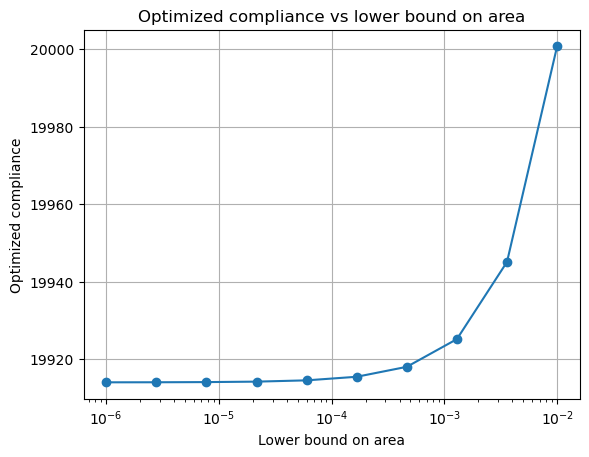

In [173]:
# consider objective scaling
# others unscaled
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

# design variable: explore various lower bound from 1e-6 to 1e-2
Ahat_min = np.logspace(-6, -2, 10) 

compliance_array = []
for Amin in Ahat_min:
    print("Lower bound on area: ", Amin)
    bounds = [(Amin, 1e3)] * len(conn)
    x0 = 1*np.ones(len(conn))
    res = minimize(prob2.compliance_scaled, x0, 
               method='SLSQP',
               bounds=bounds,
               constraints=[{'type': 'ineq',
                             'fun': lambda x: (m_fixed - np.dot(m0, x)),
                             'jac': lambda x: -np.array(m0)}])
    print('Optimized mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)
    print('Optimized compliance is ', prob2.compliance_scaled(res.x)*prob2.compliance_scale)
    print('---')

    compliance_array.append(prob2.compliance_scaled(res.x)*prob2.compliance_scale)


# plot compliance vs lower bound
plt.figure()
plt.semilogx(Ahat_min, compliance_array, '-o')
plt.xlabel('Lower bound on area')
plt.ylabel('Optimized compliance')
plt.title('Optimized compliance vs lower bound on area')
plt.grid(True)
plt.show()

### (e) Vary the lower bound over the range Amin ∈ [10−6, 10−2] and plot the maximum strain in any of the bars in the truss.
Similarly to the previous part, the influence by the changes in lower bound is minimal. Overall we see that as the lower bound increases, the max strain from the bars slightly increases. This accounts for both compression and extension as the max strain takes the absolute values.

Lower bound on area:  1e-06
Optimized mass is  30.142135623730972 , and mass limit is  30.14213562373095
Optimized compliance is  19913.992741804475
---
Lower bound on area:  2.782559402207126e-06


/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Optimized mass is  30.142135623730965 , and mass limit is  30.14213562373095
Optimized compliance is  19914.00813901652
---
Lower bound on area:  7.742636826811277e-06
Optimized mass is  30.142135623730958 , and mass limit is  30.14213562373095
Optimized compliance is  19914.051062960818
---
Lower bound on area:  2.1544346900318823e-05
Optimized mass is  30.142135623730997 , and mass limit is  30.14213562373095
Optimized compliance is  19914.170132601805
---
Lower bound on area:  5.994842503189409e-05
Optimized mass is  30.142135623730987 , and mass limit is  30.14213562373095
Optimized compliance is  19914.501682940343
---
Lower bound on area:  0.0001668100537200059
Optimized mass is  30.142135623730947 , and mass limit is  30.14213562373095
Optimized compliance is  19915.424320529342
---
Lower bound on area:  0.00046415888336127773
Optimized mass is  30.142135623730944 , and mass limit is  30.14213562373095
Optimized compliance is  19917.99187695333
---
Lower bound on area:  0.001291

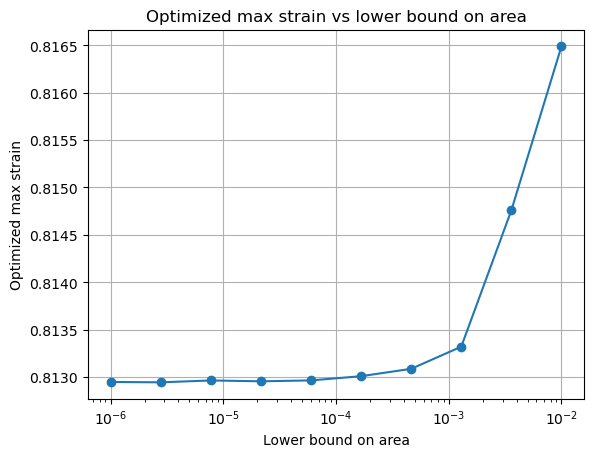

In [176]:
# AGAIN: consider objective scaling
# others unscaled
prob2 = Truss(conn, xpos, bcs, force, E=E, rho=rho)

xd = prob2.x[prob2.conn[:,1],0] - prob2.x[prob2.conn[:,0],0]
yd = prob2.x[prob2.conn[:,1],1] - prob2.x[prob2.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

# design variable: explore various lower bound from 1e-6 to 1e-2
Ahat_min = np.logspace(-6, -2, 10) 

max_strain_array = []
for Amin in Ahat_min:
    print("Lower bound on area: ", Amin)
    bounds = [(Amin, 1e3)] * len(conn)
    x0 = 1*np.ones(len(conn))
    res = minimize(prob2.compliance_scaled, x0, 
               method='SLSQP',
               bounds=bounds,
               constraints=[{'type': 'ineq',
                             'fun': lambda x: (m_fixed - np.dot(m0, x)),
                             'jac': lambda x: -np.array(m0)}])
    print('Optimized mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)
    print('Optimized compliance is ', prob2.compliance_scaled(res.x)*prob2.compliance_scale)
    print('---')

    u = prob2.solve(res.x)
    max_strain_array.append(prob2.compute_max_strain(u))


# plot compliance vs lower bound
plt.figure()
plt.semilogx(Ahat_min, max_strain_array, '-o')
plt.xlabel('Lower bound on area')
plt.ylabel('Optimized max strain')
plt.title('Optimized max strain vs lower bound on area')
plt.grid(True)
plt.show()

# Problem 3
The following question is based on a ground structure for the set of N nodes given at the following locations for k = 1, ... , N:
$x_k = \text{cos}\left(\frac{(k-1)}{N-1}\pi  \right)$, $y_k = \text{sin}\left(\frac{(k-1)}{N-1}\pi  \right)$

In [12]:
class TopoTruss:
    def __init__(self, conn, x, bcs, f, E=10.0, rho=0.1, p=3.0):
        self.conn = np.array(conn, dtype=int)
        self.x = np.array(x)
        self.bcs = np.array(bcs, dtype=int)
        self.f = np.array(f)
        self.E = E
        self.rho = rho
        self.p = p

        # Extract the number of nodes and elements
        self.nnodes = self.x.shape[0]
        self.nelems = self.conn.shape[0]

        # Form the reduced set of degrees of freedom
        self.reduced = np.setdiff1d(np.arange(2*self.nnodes), self.bcs)

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.elem_vars = np.array((2*self.conn[:,0],
                                   2*self.conn[:,0]+1,
                                   2*self.conn[:,1],
                                   2*self.conn[:,1]+1)).T
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.elem_vars[index, :]:
                for jj in self.elem_vars[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

        return

    def assemble_stiffness_matrix(self, A):
        """
        Assemble the stiffness matrix
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*Le*(A**self.p)

        # Compute all of the element matrices
        Ke = np.zeros((self.nelems, 4, 4), dtype=A.dtype)
        for i in range(self.nelems):
            Ke[i,:] = scale[i]*np.outer(B[i,:], B[i,:])

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K

    def compliance(self, A):
        """
        Given the cross-sectional areas, compute the compliance
        """

        u = self.solve(A)
        return np.dot(u, self.f)

    def compliance_gradient(self, A):
        """
        Given the cross-sectional areas, compute the compliance gradient
        """

        u = self.solve(A)

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = u[self.elem_vars]
        strain = np.sum(B*ue, axis=1)

        scale = self.E*Le*self.p*(A**(self.p - 1))
        dcdA = -scale*strain**2

        return dcdA

    def compute_stresses(self, u):
        """
        Compute the stresses in each element
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = np.array((u[2*self.conn[:,0]],
                       u[2*self.conn[:,0]+1],
                       u[2*self.conn[:,1]],
                       u[2*self.conn[:,1]+1])).T

        stress = self.E*np.sum(B*ue, axis=1)
        return stress

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def solve(self, A):
        """
        Perform a linear static analysis
        """

        K = self.assemble_stiffness_matrix(A)
        Kr = self.reduce_matrix(K)
        fr = self.reduce_vector(self.f)

        ur = sparse.linalg.spsolve(Kr, fr)

        u = np.zeros(2*self.nnodes, dtype=ur.dtype)
        u[self.reduced] = ur

        return u

    def plot(self, u=None, scale=1.0, **kwargs):
        """
        Visualize the truss and optionally its deformation.
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        if u is not None:
            x = self.x + scale*u.reshape((-1, 2))
        else:
            x = self.x

        for index in range(self.nelems):
            i = self.conn[index, 0]
            j = self.conn[index, 1]
            plt.plot([x[i,0], x[j,0]], [x[i,1], x[j,1]], '-ko')

        ax.axis('equal')
        ax.set_axis_off()
        fig.tight_layout()

        return

    def plot_areas(self, A, **kwargs):
        """
        Plot the bar areas
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        stress = self.compute_stresses(self.solve(A))

        cm = plt.get_cmap('coolwarm')
        cNorm = colors.Normalize(vmin=min(stress), vmax=max(stress))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        for index, bar in enumerate(conn):
            n1 = bar[0]
            n2 = bar[1]
            if A[index] >= 1e-4*max(A):
                plt.plot([self.x[n1, 0], self.x[n2, 0]],
                         [self.x[n1, 1], self.x[n2, 1]],
                         color=scalarMap.to_rgba(stress[index]),
                         linewidth=5*(A[index]/max(A)))

        ax.axis('equal')
        ax.set_axis_off()
        fig.tight_layout()

        return


### (a): Using the bar areas as design variables, optimize the trusses for the cases N = 5, 10, 25, 40, 50 with the mass constraint m_{fixed} = 1

Response: see the results output below. N = 50 takes more than 30 mins so it was not included in the calculation. 

Start N =  5
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 34744.36957855027
            Iterations: 53
            Function evaluations: 114
            Gradient evaluations: 49
Mass is  1.0008031668193946 , and mass limit is  1
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 34744.36957855027
       x: [ 1.181e-01  3.718e-02 ...  3.433e-02  1.124e-01]
     nit: 53
     jac: [-2.601e+04 -4.884e+04 ... -5.658e+04 -2.871e+04]
    nfev: 114
    njev: 49
Start N =  10


/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/donglaiyang/anaconda3/envs/SciML/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Iteration limit reached    (Exit mode 9)
            Current function value: 23290.13813337183
            Iterations: 100
            Function evaluations: 439
            Gradient evaluations: 100
Mass is  1.0126173243052425 , and mass limit is  1
 message: Iteration limit reached
 success: False
  status: 9
     fun: 23290.13813337183
       x: [ 5.617e-02  4.046e-02 ...  6.058e-02  4.684e-02]
     nit: 100
     jac: [-8.970e+03 -1.563e+04 ... -1.630e+04 -9.088e+03]
    nfev: 439
    njev: 100
Start N =  25
Iteration limit reached    (Exit mode 9)
            Current function value: 16198.84071180684
            Iterations: 100
            Function evaluations: 425
            Gradient evaluations: 100
Mass is  1.6299677569042919 , and mass limit is  1
 message: Iteration limit reached
 success: False
  status: 9
     fun: 16198.84071180684
       x: [ 8.673e-02  1.177e-02 ...  1.909e-02  6.588e-02]
     nit: 100
     jac: [-2.085e+03 -4.164e+03 ... -3.786e+03 -2.896e+03]
    nfev: 

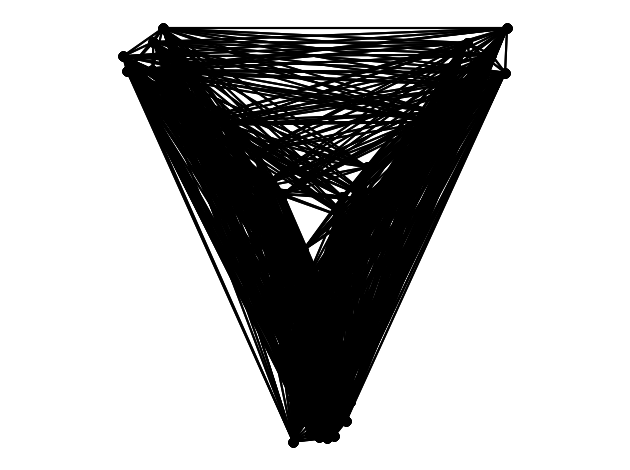

Mass is  2.342986753361112 , and mass limit is  1


In [13]:
E = 1.0
rho = 1.0
Ns = [5, 10, 25, 40]
# Ns = [10]
m_fixed = 1

# generate all truss objects at various N
truss_all = []
for N in Ns:
    # Generate node positions
    pos = []
    for k in range(N):
        xpos = np.cos(k*np.pi/(N-1))
        ypos = np.sin(k*np.pi/(N-1))
        pos.append([xpos, ypos])
    pos = np.array(pos)

    # Generate connectivity
    conn = []
    for i in range(N):
        for j in range(N):
            if i != j:
                conn.append([i, j])
    conn = np.array(conn)

    # Boundary conditions: 
    # - First node (k=1) fixed in both x and y
    # - Last node (k=N) fixed in y direction
    bcs = [0, 1, 2*(N-1)+1]

    # Forces: nodes k=2 to k=N-1 have force 100/(N-2)
    force = np.zeros(2*N)
    for k in range(1, N-1): 
        force[2*k + 1] = -100/(N-2)

    # Create truss
    truss = Truss(conn, pos, bcs, force, E=E, rho=rho)
    truss_all.append(truss)

options = {
    'maxiter': 100,  # Limit to 50 iterations
    'disp': True    # Display convergence messages
}

# for each truss, optimize the bar area
n_iter = []
compliance_all = []
for truss in truss_all:
    x0 = 1*np.ones(len(truss.conn))
    # Compute the gradient of the mass of the truss
    xd = truss.x[truss.conn[:,1],0] - truss.x[truss.conn[:,0],0]
    yd = truss.x[truss.conn[:,1],1] - truss.x[truss.conn[:,0],1]
    Le = np.sqrt(xd**2 + yd**2)
    m0 = rho*Le

    # no scaling
    print("======================================")
    print("Start N = ", truss.nnodes)
    res = minimize(truss.compliance, x0, 
                    jac=truss.compliance_gradient,
                    method='SLSQP',
                    bounds=[(1e-6, 1)]*len(x0),
                    constraints=[{'type': 'ineq',
                                'fun': lambda x: (m_fixed - np.dot(m0, x)),
                                'jac': lambda x: -np.array(m0)}],
                                options=options)
    print('Mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)

    # Show the bar areas
    print(res)

    # append number of iterations and compliance
    n_iter.append(res.nit)
    compliance_all.append(truss.compliance(res.x))

# plot
u = truss.solve(res.x)
truss.plot(u=u)
plt.show()
# print mass
print('Mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed)

### (b) Optimize the same set of trusses using SIMP Penalization with P = 3. This time use the fixed mass constraint m_{fixed} = N/4

Responses: this time the optimizations take much fewer iterations and in all scenarios the mass inequality constraint is almost satistified, suggesting that penalization is a necessary method for such a problem. 

In [14]:
E = 1.0
rho = 1.0
Ns = [5, 10, 25, 40]
# Ns = [10]
m_fixed = np.array(Ns)/4 
p = 3.0

# generate all truss objects at various N
topotruss_all = []
for N in Ns:
    # Generate node positions
    pos = []
    for k in range(N):
        xpos = np.cos(k*np.pi/(N-1))
        ypos = np.sin(k*np.pi/(N-1))
        pos.append([xpos, ypos])
    pos = np.array(pos)

    # Generate connectivity
    conn = []
    for i in range(N):
        for j in range(N):
            if i != j:
                conn.append([i, j])
    conn = np.array(conn)

    # Boundary conditions: 
    # - First node (k=1) fixed in both x and y
    # - Last node (k=N) fixed in y direction
    bcs = [0, 1, 2*(N-1)+1]

    # Forces: nodes k=2 to k=N-1 have force 100/(N-2)
    force = np.zeros(2*N)
    for k in range(1, N-1): 
        force[2*k + 1] = -100/(N-2)

    # Create truss
    topotruss = TopoTruss(conn, pos, bcs, force, E=E, rho=rho, p=p)
    topotruss_all.append(topotruss)

options = {
    'maxiter': 100,  # Limit to 100 iterations
    'disp': True    # Display convergence messages
}

# for each truss, optimize the bar area
topo_n_iter = []
topo_compliance_all = []
for idx, topotruss in enumerate(topotruss_all):
    x0 = 1*np.ones(len(topotruss.conn))
    # Compute the gradient of the mass of the truss
    xd = topotruss.x[topotruss.conn[:,1],0] - topotruss.x[topotruss.conn[:,0],0]
    yd = topotruss.x[topotruss.conn[:,1],1] - topotruss.x[topotruss.conn[:,0],1]
    Le = np.sqrt(xd**2 + yd**2)
    m0 = rho*Le

    # no scaling
    print("======================================")
    print("Start N = ", topotruss.nnodes)
    res = minimize(topotruss.compliance, x0, 
                    jac=topotruss.compliance_gradient,
                    method='SLSQP',
                    bounds=[(1e-6, 1)]*len(x0),
                    constraints=[{'type': 'ineq',
                                'fun': lambda x: (m_fixed[idx] - np.dot(m0, x)),
                                'jac': lambda x: -np.array(m0)}],
                                options=options)
    print('Mass is ', np.dot(m0, res.x),', and mass limit is ', m_fixed[idx])

    # Show the bar areas
    print(res)

    # append number of iterations and compliance
    topo_n_iter.append(res.nit)
    topo_compliance_all.append(topotruss.compliance(res.x))


Start N =  5
dgstrf info 7
dgstrf info 7
dgstrf info 7
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1374985957312.7205
            Iterations: 15
            Function evaluations: 37
            Gradient evaluations: 15
Mass is  1.333869795550621 , and mass limit is  1.25
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 1374985957312.7205
       x: [ 1.345e-02  1.000e-06 ...  9.521e-04  1.168e-02]
     nit: 15
     jac: [-2.836e+10 -3.558e+09 ... -5.236e+14 -4.111e+10]
    nfev: 37
    njev: 15
Start N =  10
dgstrf info 17
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 548590034975.27795
            Iterations: 8
            Function evaluations: 23
            Gradient evaluations: 8
Mass is  2.5618999153747564 , and mass limit is  2.5
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 548590034975.27795
       x: [ 9.990e-01  4.062e

/tmp/ipykernel_5954/2536396716.py:155: MatrixRankWarning: Matrix is exactly singular
  ur = sparse.linalg.spsolve(Kr, fr)


Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2080983823.6750903
            Iterations: 9
            Function evaluations: 33
            Gradient evaluations: 9
Mass is  7.995522114714364 , and mass limit is  6.25
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 2080983823.6750903
       x: [ 3.287e-03  1.000e+00 ...  1.000e+00  2.312e-03]
     nit: 9
     jac: [-1.257e+10 -4.671e+01 ... -7.174e+01 -3.750e+10]
    nfev: 33
    njev: 9
Start N =  40
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3.679215897559117e+16
            Iterations: 13
            Function evaluations: 24
            Gradient evaluations: 13
Mass is  10.000000038477639 , and mass limit is  10.0
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: -3.679215897559117e+16
       x: [ 1.000e-06  1.001e-06 ...  1.001e-06  1.000e-06]
     nit: 13
     jac: [-7.675e+

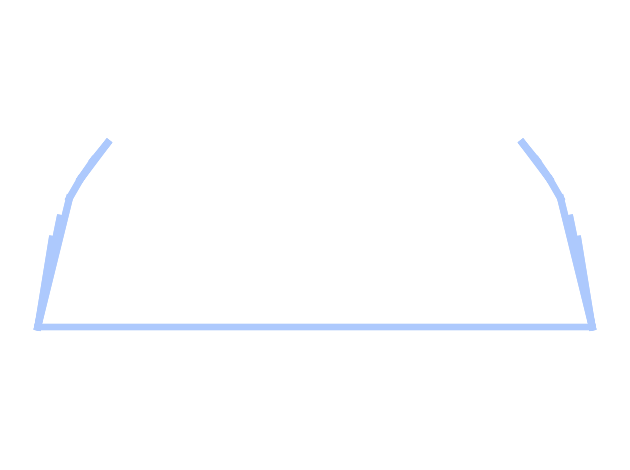

In [15]:
# plot the last one as an example
topotruss.plot_areas(res.x)
plt.show()

### (c) Plot the compliance of the optimized trusses for both the sizing and SIMP trusses

Response: While the first plot from below shows that the original truss optimization approach finds lower compliance than the SIMP approach, we should be aware that none of those optimizations converge within the max iteration (second plot below), and the optimized mass all exceed the mass inequality constraint. Therefore, SIMP penalization improves the problem convergence and solution. 

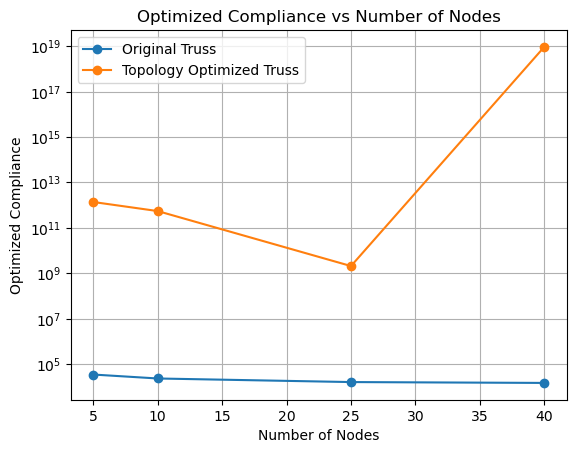

In [16]:
# plot the optimized compliance from the original truss and the topology optimized truss
plt.figure()
plt.semilogy(Ns, compliance_all, '-o', label='Original Truss')
plt.semilogy(Ns, topo_compliance_all, '-o', label='Topology Optimized Truss')
plt.xlabel('Number of Nodes')
plt.ylabel('Optimized Compliance')
plt.title('Optimized Compliance vs Number of Nodes')
plt.legend()
plt.grid(True)
plt.show()

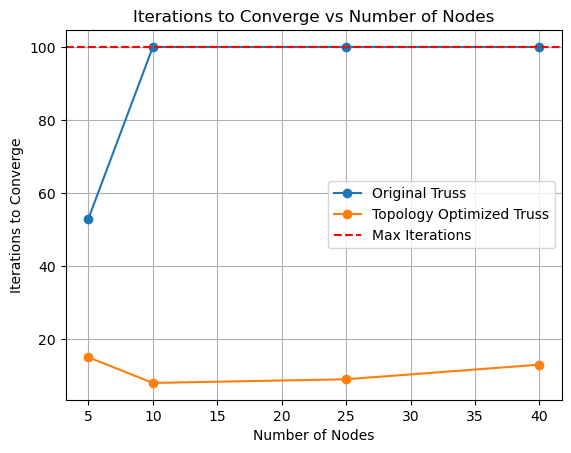

In [17]:
# plot the number of iterations taken
plt.figure()
plt.plot(Ns, n_iter, '-o', label='Original Truss')
plt.plot(Ns, topo_n_iter, '-o', label='Topology Optimized Truss')
# add a line of max iterations (50)
plt.axhline(y=options['maxiter'], color='r', linestyle='--', label='Max Iterations')
plt.xlabel('Number of Nodes')
plt.ylabel('Iterations to Converge')
plt.title('Iterations to Converge vs Number of Nodes')
plt.legend()
plt.grid(True)
plt.show()